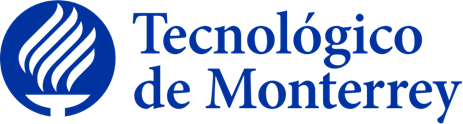

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries

In [1]:
from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
from peft import PeftModel

# from unsloth import FastLanguageModel
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import json
from dotenv import load_dotenv
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.modeling_utils import PreTrainedModel

from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import re


/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
demo_mode = False
model_name = "unsloth/mistral-7b-v0.3-bnb-4bit"
dataset_url = "JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts"
peft_model_name = 'rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2'

### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [3]:
def extract_response(response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )
    
def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
    '''
    Generates the response from the model
    '''
    
    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 650, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)
    
    return extract_response(result[0])

def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []
    
    if isinstance(datapoints, Dataset):
        datapoints = convert_hugging_face_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        if (isinstance(golden, Golden)):
            datapoint = json.loads(golden.model_dump_json())
        
        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue
    
    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases 

def convert_hugging_face_dataset_to_goldens(dataset: Dataset)->list[Golden]:
    
    goldens = []
    
    for datapoint in dataset:
        if (type(datapoint['context']) != str): 
            continue#We need context for some tests
        test_case = Golden(
            input = datapoint['instruction'],
            expected_output = datapoint['output'],
            context = [datapoint['context']]
        )
        
        test_case.expected_output = datapoint['output']
        
        goldens.append(test_case)
        
    return goldens
        
        


### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [4]:
dataset = load_dataset(dataset_url)
test_set = dataset['test']

In [5]:
load_dotenv()

True

### 3. Setting up the Finetuned Model

We proceed to download the main model, which was a quantized version of the Llama-3-8b. In order to run this code, it'necessary to have cuda device.

In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,
    device_map='cuda',
    load_in_4bit = True,
)


==((====))==  Unsloth: Fast Mistral patching release 2024.6
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.151 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: Will load unsloth/mistral-7b-v0.3-bnb-4bit as a legacy tokenizer.


Now we donwload the PEFT model containing the trained weights

In [7]:

model = PeftModel.from_pretrained(model, model_id=peft_model_name)
FastLanguageModel.for_inference(model)

We define the prompt that we will provide to the Llama Model

In [8]:
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

### 4. Evaluating the Model

First, let's load the dataset containing all the goldens

Now, we create the test cases from the goldens. For the real evaluation we used 250+ testcases, For demonstration purposes, we will use only 10 testcases.

In [9]:
len(test_set)

1120

In [12]:
dataset = test_set.train_test_split(test_size=0.2)

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'context', 'text'],
        num_rows: 896
    })
    test: Dataset({
        features: ['instruction', 'output', 'context', 'text'],
        num_rows: 224
    })
})

In [15]:
test_cases = generate_test_cases(model, tokenizer, dataset['test'], alpaca_based_prompt)
test_cases[:5]

Generating test cases:   0%|          | 0/222 [00:00<?, ?it/s]

Generating test cases: 100%|██████████| 222/222 [25:47<00:00,  6.97s/it]


[LLMTestCase(input='Redacta una cláusula para un contrato de importación de merluzas que establezca las condiciones de acuerdo con el Artículo 0305.59.01 de la Ley de los Impuestos Generales de Importación y de Exportación.', actual_output='CLÁUSULA DECIMOSEXTA.- IMPORTACIÓN DE MERLUZAS. Las partes acuerdan que la importación de merluzas estará sujeta a las disposiciones del Artículo 0305.59.01 de la Ley de los Impuestos Generales de Importación y de Exportación, incluyendo los requisitos de clasificación arancelaria y los términos de importación.</s>', expected_output='CLÁUSULA DECIMOTERCERA - IMPORTACIÓN DE MERLUZAS. Las partes acuerdan que la importación de merluzas estará sujeta a las disposiciones del Artículo 0305.59.01 de la Ley de los Impuestos Generales de Importación y de Exportación, que establece un límite máximo de 20 kilogramos por importación. Cualquier incumplimiento de esta cláusula resultará en las sanciones correspondientes según la ley.', context=['Ley de los Impues

Sometimes the Llama model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [16]:
test_cases = exclude_test_cases_with_empty_outputs(test_cases)

A total of 4 testcases were removed from the set


In [17]:
dataset = EvaluationDataset(test_cases)

In [18]:
from deepeval.dataset.utils import convert_test_cases_to_goldens

goldens = convert_test_cases_to_goldens(test_cases)

In [19]:
backup_dataset = EvaluationDataset(goldens = goldens)
backup_dataset.save_as('json', './test_cases')

Evaluation dataset saved at ./test_cases/20240614_232842.json!


'./test_cases/20240614_232842.json'

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [ ]:
with open('./test_cases/')

In [50]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

In [20]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

No we get the results from the evaluation

In [21]:
results = evaluate(dataset, [hallucination_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/home/rmateoc/.pyenv/versions/3.11.9/envs/proy_integrador/lib/python3.11/site-packages/por

Results saved in ./test_results as 20240614_233442

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [48]:
with open('./test_results/20240614_215333') as f:
    results = json.load(f)
    
clean_results = []
for test_case in results['testCases']:
    for metric in test_case['metricsMetadata']:
        if 'error' in metric and metric['error'] == 'Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.':
            continue
    
        clean_results.append(metric)

KeyboardInterrupt: 

In [40]:
len(clean_results)

1105

In [43]:
clean_results[10]

{'metric': 'Answer Relevancy',
 'threshold': 0.7,
 'success': True,
 'score': 1.0,
 'reason': 'The score is 1.00 because the answer is completely relevant to the question asked.',
 'strictMode': False,
 'evaluationModel': 'gpt-3.5-turbo',
 'evaluationCost': 0.0014045000000000001}

In [21]:
clean_results[0]

{'name': 'test_case_0',
 'input': '¿Qué información debe enviar el Banco de México al Ejecutivo Federal y al Congreso de la Unión según el Artículo 51 de la Ley del Banco de México?',
 'actualOutput': 'El Banco de México debe enviar al Ejecutivo Federal y al Congreso de la Unión informes periódicos sobre su actuación, así como los documentos que se refieran a las operaciones en las que intervenga, a petición de la Comisión.</s>',
 'context': ['Ley del Banco de México - Artículo 51. El Banco enviará al Ejecutivo Federal y al Congreso de la Unión y, en los recesos de este último, a su Comisión Permanente, lo siguiente: I. En enero de cada año, una exposición sobre la política monetaria a seguir por la Institución en el ejercicio respectivo, así como un informe sobre el presupuesto de gasto corriente e inversión física de la Institución, correspondiente a dicho ejercicio, y II. A más tardar cuarenta y cinco días hábiles después del cierre de cada trimestre, un informe sobre la inflación, 

In [45]:
hallucination_metric = []
for metric in clean_results:
        if metric['metric'] == 'Hallucination':
            hallucination_metric.append(metric)
            
            

hallucination_metric[0]

{'metric': 'Hallucination',
 'threshold': 0.3,
 'success': False,
 'score': 1.0,
 'reason': 'The score is 1.00 because the actual output lacks important details such as the specific content of the reports and the timeline for submission, which are crucial for a complete understanding.',
 'strictMode': False,
 'evaluationModel': 'gpt-3.5-turbo',
 'evaluationCost': 0.0016219999999999997}

In [46]:
len(hallucination_metric)

9

In [47]:
passed = 0

for metric in hallucination_metric:
    if metric['success'] == True:
        passed+=1
        

passed/len(hallucination_metric)

0.1111111111111111

In [30]:
len(hallucination_metric)

548

In [24]:
passed

1

Now we print the scores:

In [22]:
scores = aggregate_metric_pass_rates(results)

if not demo_mode:
    with open('./test_results/test_results.json', 'w') as f:
        json.dump(scores, f)



Overall Metric Pass Rates

HallucinationMetric: 37.61% pass rate




In case the notebook is in demo mode, we load the real scores and print them out:

In [21]:
if demo_mode:
    with open('./test_results/test_results.json') as f:
        scores = json.load(f)
        
    print("\n" + "=" * 70 + "\n")
    print("Overall Metric Pass Rates\n")
    for metric, pass_rate in scores.items():
        print(f"{metric}: {pass_rate:.2%} pass rate")
    print("\n" + "=" * 70 + "\n")




Overall Metric Pass Rates

HallucinationMetric: 4.03% pass rate
AnswerRelevancyMetric: 92.62% pass rate
GEval: 89.93% pass rate




### 5. Conclusions

The model has a good performance on the GEval and Answer Relevancy metrics (92.62% and 89.93$ respectively). Nonetheless, the hallucination metric is not satisfactory (4.03%) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

Because the model has low score in the hallucination metric, it's still not ready for production.